In [12]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import old_references.nonlinear_QM_FPJPA as Fs
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
import standard_sequences.rabi_ef_no_swap as rabi_ef_no_swap
import classifiers.classifier as classifier
import analysis.analysis as analysis
import seaborn as sns
import analysis.plotting as plotting

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_pwr"],
    bnc_addr=bnc_address["big_agilent"],
)
general_vals_dict["wx_offs"] = [0.7, 0, -0.08, 0]  # offset to sweet spot

Qubit(RO_IF=None, ge_ssm=-0.1145, qubit_thr=[-10000, -600], RO_LO=6.6247, ro_dur=4000, ef_time=48.99547631778931, ro_freq=6.72745, ro_amp=1, ge_time=81.06104804214716, IQ_angle=205, RO_LO_pwr=16, qubit_id=q1, ROIF=0.10275000000000034, ge_amp=0.8, ef_ssm=-0.25684, ef_amp=1.5)
Qubit(RO_IF=None, ge_ssm=-0.154, qubit_thr=[-10000, 1900], RO_LO=6.6247, ro_dur=4000, ef_time=None, ro_freq=6.6556, ro_amp=1.5, ge_time=45.047198597262124, IQ_angle=85, RO_LO_pwr=16, qubit_id=q2, ROIF=0.030899999999999928, ge_amp=0.8, ef_ssm=-0.2962, ef_amp=1)


In [4]:
def run_rabi(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_no_swap.rabi_ef_no_swap(q1, q2, general_vals_dict, num_steps, sweep_time)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values

In [29]:
df_prob, df_pop, values = run_rabi(
    q1, q2, general_vals_dict, num_steps=100, sweep_time=5000, reps=100
)

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 100
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 100
Records per pattern: 100
Buffers per acquistion: 4
DAQ samples per pattern: 8192
0, No error
Capturing 4 buffers. Press <enter> to abort
Capture completed in 2.017223 sec
Captured 4 buffers (1.982924 buffers per sec)
Captured 12288 records (6091.541599 records per sec)
Transferred 201326592 bytes (99803817.552563 bytes per sec)


(0.0, 1.0)

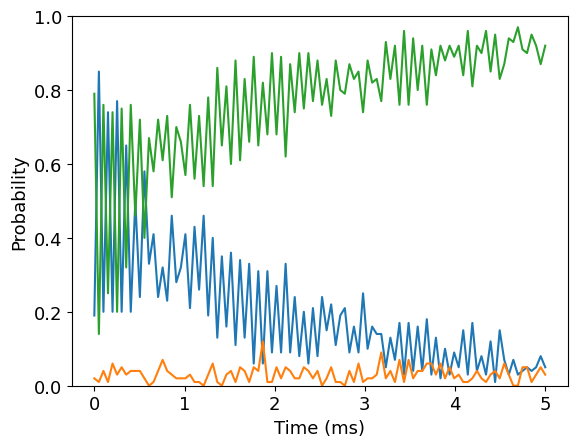

In [32]:
plt.figure(dpi=100)
plt.plot(df_prob["time"], df_prob["P_f"], label="P_f")
plt.plot(df_prob["time"], df_prob["P_e"], label="P_e")
plt.plot(df_prob["time"], df_prob["P_g"], label="P_g")
plt.xlabel("Time (ms)")
plt.ylabel("Probability")
plt.ylim(0, 1)

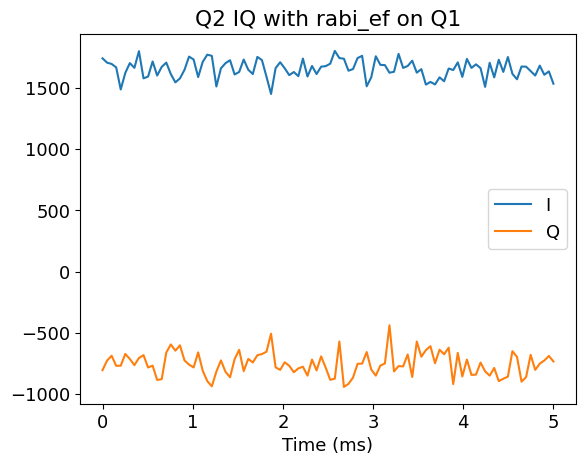

In [33]:
values_avg_df = plotting.get_IQ_averages(values)
plt.figure(dpi=100)
plt.plot(df_prob["time"], values_avg_df["I2"], label="I")
plt.plot(df_prob["time"], values_avg_df["Q2"], label="Q")
plt.title("Q2 IQ with rabi_ef on Q1")
plt.xlabel("Time (ms)")
plt.legend()

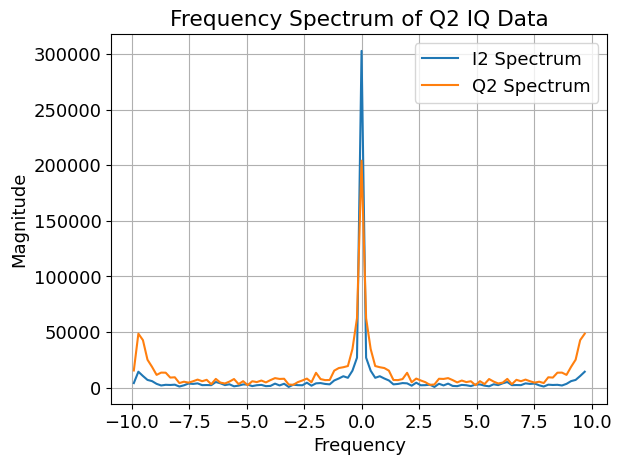

In [45]:
# Extract time and IQ data
time = df_prob["time"]  # Time values in ms
I2 = values_avg_df["I1"]  # I2 values
Q2 = values_avg_df["Q1"]  # Q2 values

# Compute the Fourier Transform
# Use numpy.fft.fft to compute the FFT
I2_fft = np.fft.fft(I2)
Q2_fft = np.fft.fft(Q2)

# Compute the frequency axis
# The frequency resolution is determined by the time step
dt = time.iloc[1] - time.iloc[0]  # Time step in ms
N = len(time)  # Number of data points
frequencies = np.fft.fftfreq(N, d=dt)  # Frequency axis in kHz (since time is in ms)

# Shift the zero frequency component to the center
I2_fft_shifted = np.fft.fftshift(I2_fft)
Q2_fft_shifted = np.fft.fftshift(Q2_fft)
frequencies_shifted = np.fft.fftshift(frequencies)

# Plot the frequency spectrum
plt.figure(dpi=100)
plt.plot(frequencies_shifted, np.abs(I2_fft_shifted), label="I2 Spectrum")
plt.plot(frequencies_shifted, np.abs(Q2_fft_shifted), label="Q2 Spectrum")
plt.title("Frequency Spectrum of Q2 IQ Data")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()
plt.show()

In [40]:
print(time.iloc[1])

0.050505050505050504
